In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from os.path import join, isfile
import optuna
import scipy
import pickle
import json
import ili
from ili.utils.ndes_pt import LampeEnsemble

from toolbox.priors import get_priors, get_param_ranges
from toolbox.utils import load_posterior
from toolbox.simulators import syren_simulator, sample_uniform_lhs

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)


/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## STEP 1 - Generate Training Data and Setup Optuna Studies

In [2]:
# Global constants
L, N = 1000, 64
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

In [3]:
# Get parameter ranges and priors
n_simulations = 10000
param_ranges = get_param_ranges()
prior_normal, prior_uniform, prior_tailed = get_priors(device)

In [4]:
# Sample from proposals
theta_uniform = sample_uniform_lhs(
    n_samples=n_simulations, param_ranges=param_ranges)
theta_tailed = prior_tailed.sample_lhs(n_simulations)

# Run simulations
x_uniform = np.array([syren_simulator(theta_uniform[i].numpy(), L=L, N=N, a=a)
                      for i in range(n_simulations)])
x_tailed = np.array([syren_simulator(theta_tailed[i].numpy(), L=L, N=N, a=a)
                     for i in range(n_simulations)])

# Log-normalize data
x_uniform = np.log10(x_uniform)
x_tailed = np.log10(x_tailed)

# Impute nans
mask = np.isnan(x_uniform)
x_uniform[mask] = np.nanmean(x_uniform)
mask = np.isnan(x_tailed)
x_tailed[mask] = np.nanmean(x_tailed)

# check nans
print("Number of NaNs in uniform simulations:", np.isnan(x_uniform).sum())
print("Number of NaNs in tailed simulations:", np.isnan(x_tailed).sum())

# Print parameter ranges
print("Uniform proposal parameter range: \n"
      f"\tOm={theta_uniform[:, 0].min():.3f}-{theta_uniform[:, 0].max():.3f},\n"
      f"\th={theta_uniform[:, 1].min():.3f}-{theta_uniform[:, 1].max():.3f}")
print("TailedNormal proposal parameter range: \n"
      f"\tOm={theta_tailed[:, 0].min():.3f}-{theta_tailed[:, 0].max():.3f},\n"
      f"\th={theta_tailed[:, 1].min():.3f}-{theta_tailed[:, 1].max():.3f}")

Number of NaNs in uniform simulations: 0
Number of NaNs in tailed simulations: 0
Uniform proposal parameter range: 
	Om=0.270-0.370,
	h=0.630-0.710
TailedNormal proposal parameter range: 
	Om=0.234-0.409,
	h=0.600-0.738


/tmp/ipykernel_2312285/3598398736.py:13: RuntimeWarning: invalid value encountered in log10
  x_uniform = np.log10(x_uniform)
/tmp/ipykernel_2312285/3598398736.py:14: RuntimeWarning: invalid value encountered in log10
  x_tailed = np.log10(x_tailed)


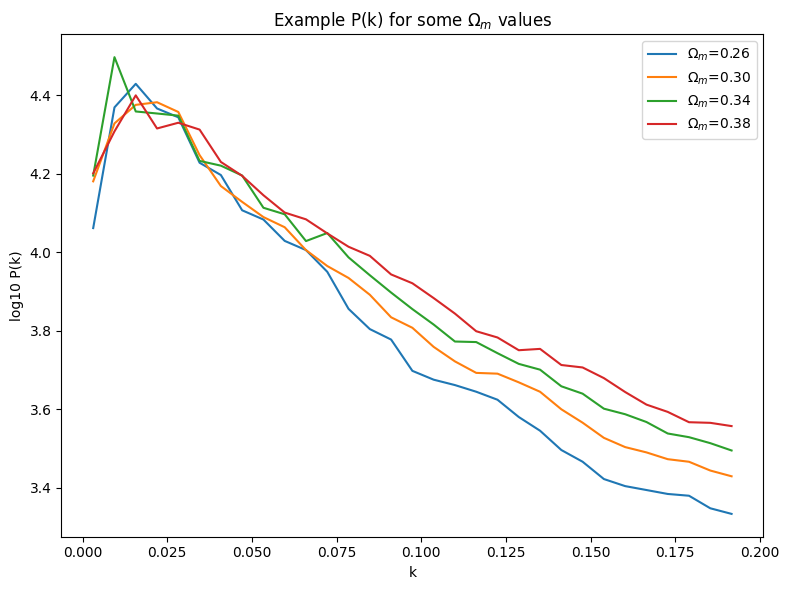

In [12]:
# Plot example simulations
omega_m_values = [0.26, 0.30, 0.34, 0.38]
h_fixed = 0.7

plt.figure(figsize=(8, 6))
for Om in omega_m_values:
    pk = syren_simulator([Om, h_fixed], L=L, N=N, a=a)
    pk = np.log10(pk)
    plt.plot(kcenters, pk, label=f'$\Omega_m$={Om:.2f}')

plt.xlabel('k')
plt.ylabel('log10 P(k)')
plt.title('Example P(k) for some $\Omega_m$ values')
plt.legend()
plt.tight_layout()
# os.makedirs('sci-2-dim-figures', exist_ok=True)
# filename = f'sci-2-dim-figures/example-samples.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')
# print(f"Saved plot: {filename}")
plt.show()

In [5]:
# Split training/test
frac_train = 0.8
seed = 42
np.random.seed(seed)
shuffled_indices = np.random.permutation(n_simulations)
split_idx = int(frac_train * n_simulations)

# Uniform
theta_uniform_train = theta_uniform[shuffled_indices[:split_idx]]
x_uniform_train = x_uniform[shuffled_indices[:split_idx]]
theta_uniform_test = theta_uniform[shuffled_indices[split_idx:]]
x_uniform_test = x_uniform[shuffled_indices[split_idx:]]

# TailedUniform
theta_tailed_train = theta_tailed[shuffled_indices[:split_idx]]
x_tailed_train = x_tailed[shuffled_indices[:split_idx]]
theta_tailed_test = theta_tailed[shuffled_indices[split_idx:]]
x_tailed_test = x_tailed[shuffled_indices[split_idx:]]

In [14]:
# SAVE THE DATA AND CREATE OPTUNA STUDIES
model_library = 'sci-2-dim-models'
os.makedirs(model_library, exist_ok=True)


def setup_optuna(exp_path, name, n_startup_trials):
    sampler = optuna.samplers.TPESampler(
        n_startup_trials=n_startup_trials,
        multivariate=True,
        constant_liar=True,
    )
    study = optuna.create_study(
        sampler=sampler,
        direction="maximize",
        storage='sqlite:///'+join(exp_path, 'optuna_study.db'),
        study_name=name,
        load_if_exists=True
    )
    return study


# Uniform NPE
model_dir = join(model_library, 'uniform_power')
os.makedirs(model_dir, exist_ok=True)
np.save(join(model_dir, 'theta_train.npy'), theta_uniform_train.numpy())
np.save(join(model_dir, 'x_train.npy'), x_uniform_train)
np.save(join(model_dir, 'theta_test.npy'), theta_uniform_test.numpy())
np.save(join(model_dir, 'x_test.npy'), x_uniform_test)
_ = setup_optuna(model_dir, 'uniform_power', n_startup_trials=10)

# TailedUniform NPE
model_dir = join(model_library, 'tailed_power')
os.makedirs(model_dir, exist_ok=True)
np.save(join(model_dir, 'theta_train.npy'), theta_tailed_train.numpy())
np.save(join(model_dir, 'x_train.npy'), x_tailed_train)
np.save(join(model_dir, 'theta_test.npy'), theta_tailed_test.numpy())
np.save(join(model_dir, 'x_test.npy'), x_tailed_test)
_ = setup_optuna(model_dir, 'tailed_power', n_startup_trials=10)

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-25 13:31:31,574] A new study created in RDB with name: uniform_power
[I 2025-11-25 13:31:31,736] A new study created in RDB with name: tailed_power


## Step 2 - Run Optuna Experiments

run `python scripts/run_optuna.py`

## Step 3 - Gather results and save final model

In [6]:
model_library = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/sci-2-dim-models'
model_name = 'uniform_power'  # 'tailed_power' or 'uniform_power'

model_dir = join(model_library, model_name)
net_dir = join(model_dir, 'nets')

/tmp/ipykernel_2312285/1290276110.py:9: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

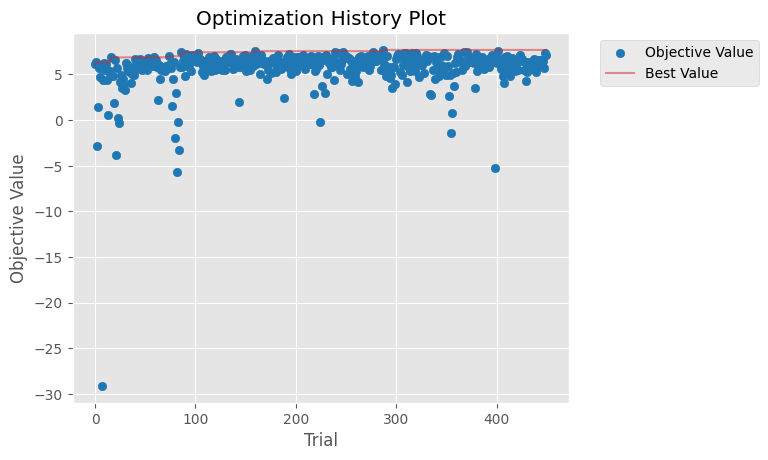

In [7]:
# Load optuna database and plot study results
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_slice

study = optuna.load_study(
    study_name=model_name,
    storage='sqlite:///'+join(model_dir, 'optuna_study.db')
)

plot_optimization_history(study)

/tmp/ipykernel_2312285/3836449081.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

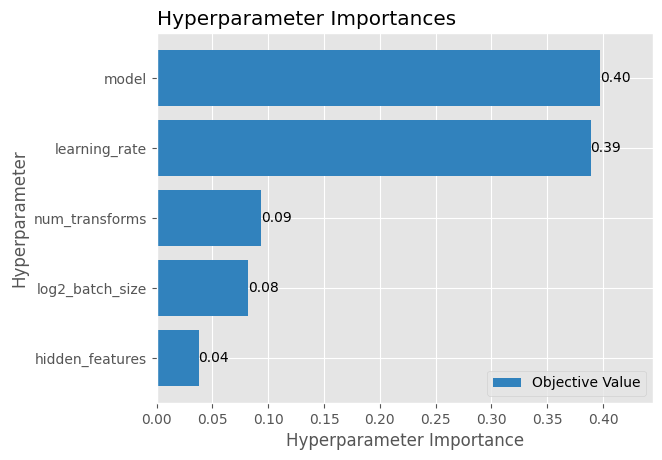

In [8]:
plot_param_importances(study)

/tmp/ipykernel_2312285/2457830863.py:1: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='hidden_features', ylabel='Objective Value'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='log2_batch_size'>,
       <Axes: xlabel='model'>, <Axes: xlabel='num_transforms'>],
      dtype=object)

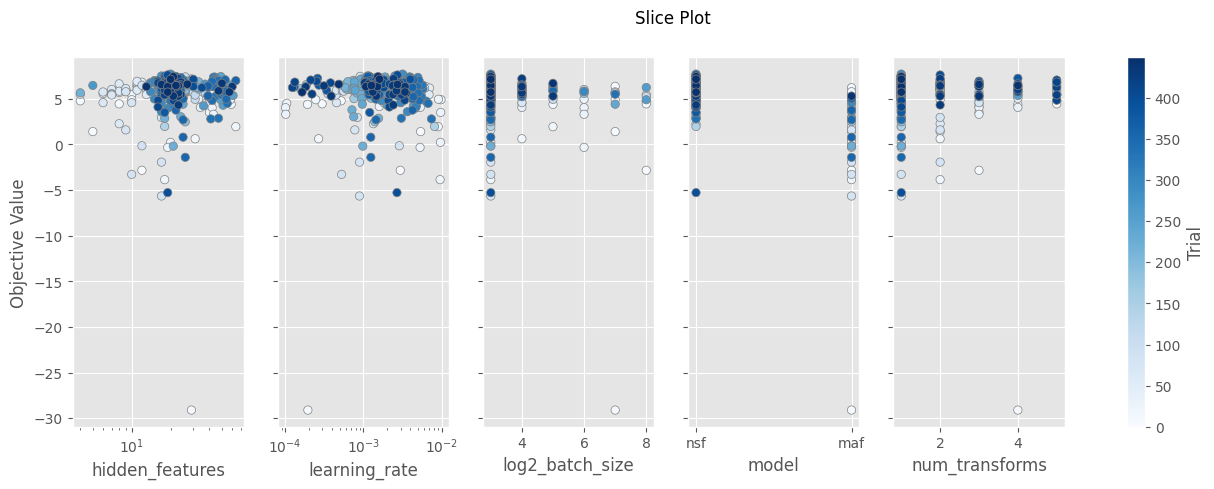

In [9]:
plot_slice(study)

In [10]:
# Collect log probabilities from all experiments

net_paths = os.listdir(net_dir)

log_probs = []
for dname in net_paths:
    exp_dir = join(net_dir, dname)
    log_prob_file = join(exp_dir, 'log_prob_test.txt')
    if os.path.exists(log_prob_file):
        with open(log_prob_file, 'r') as f:
            log_prob = float(f.read().strip())
        log_probs.append(log_prob)
    else:
        log_probs.append(-np.inf)
log_probs = np.array(log_probs)

print(f"Collected log probabilities from {len(log_probs)} experiments.")

Collected log probabilities from 450 experiments.


In [13]:
Nnets = 5  # number of top nets to ensemble
weighted = True  # whether to weight by log prob

top_nets = np.argsort(log_probs)[::-1][:Nnets]
print(f'Selected nets: {[net_paths[i] for i in top_nets]}')

ensemble_list = []
for i in top_nets:
    model_path = join(net_dir, net_paths[i], 'posterior.pkl')
    pi = load_posterior(model_path, 'cpu')
    ensemble_list.append(pi.posteriors[0])

if weighted:
    ensemble_logprobs = log_probs[top_nets]
    weights = scipy.special.softmax(ensemble_logprobs)
    weights = torch.Tensor(weights)
else:
    weights = torch.ones(len(top_nets)) / len(top_nets)

ensemble = LampeEnsemble(
    posteriors=ensemble_list,
    weights=weights  # equally weighted
)

# save ensemble
with open(join(model_dir, 'ensemble.pkl'), "wb") as handle:
    pickle.dump(ensemble, handle)

Selected nets: ['net-287', 'net-401', 'net-159', 'net-239', 'net-277']


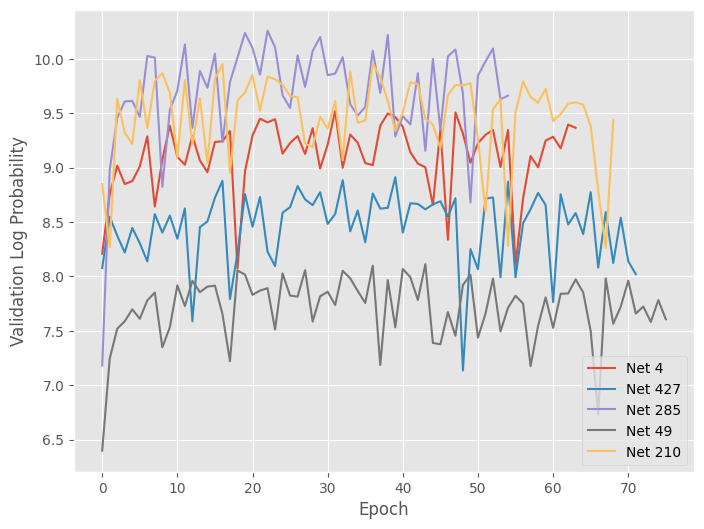

In [14]:
# plot all the losses of the top nets
f, ax = plt.subplots(figsize=(8, 6))
for i in top_nets:
    loss_file = join(net_dir, net_paths[i], 'summary.json')
    with open(loss_file, 'r') as f:
        summary = json.load(f)
    ax.plot(summary[0]['validation_log_probs'], label=f'Net {i}')
ax.set(xlabel='Epoch', ylabel='Validation Log Probability')
ax.legend()

INFO:root:Sampling models with [227, 205, 199, 186, 184] samples each.
Drawing 184 posterior samples: 100%|██████████| 184/184 [00:00<00:00, 1254.28it/s]


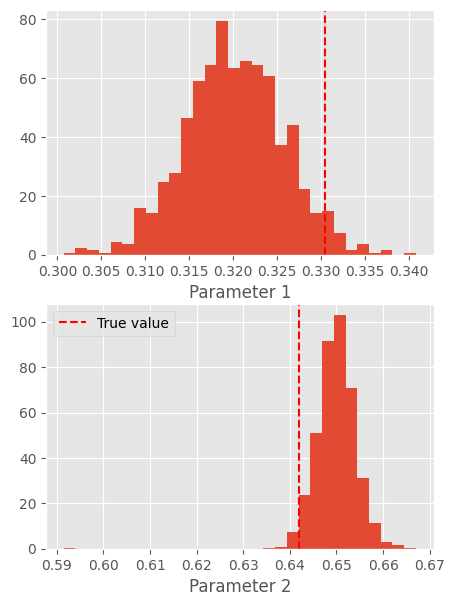

In [15]:
ind = 11
x0, y0 = x_uniform_test[ind], theta_uniform_test[ind]

out = ensemble.sample((1000,), x0).cpu().numpy()
f, axs = plt.subplots(2, 1, figsize=(5, 7))
ax = axs[0]
ax.hist(out[:, 0], bins=30, density=True)
ax.axvline(y0[0].cpu(), color='red', linestyle='--', label='True value')
ax.set_xlabel('Parameter 1')

ax = axs[1]
ax.hist(out[:, 1], bins=30, density=True)
ax.axvline(y0[1].cpu(), color='red', linestyle='--', label='True value')
ax.set_xlabel('Parameter 2')
ax.legend()

INFO:root:Sampling models with [227, 205, 199, 186, 184] samples each.
Drawing 184 posterior samples: 100%|██████████| 184/184 [00:00<00:00, 1350.60it/s]


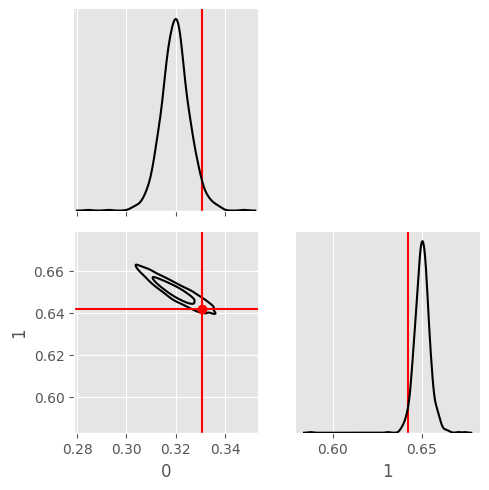

In [16]:
metric = ili.validation.metrics.PlotSinglePosterior(
    num_samples=1000, labels=range(2),
    sample_method='direct')
metric(ensemble, x_obs=x0, theta_fid=y0)

/tmp/ipykernel_2312285/1929046996.py:12: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
/tmp/ipykernel_2312285/1929046996.py:13: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


Collected log probabilities from 439 experiments.
Selected nets: ['net-427', 'net-248', 'net-333', 'net-329', 'net-409']


/anvil/scratch/x-ctirapongpra/tailed-uniform-sbi/notebooks/toolbox/utils.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_

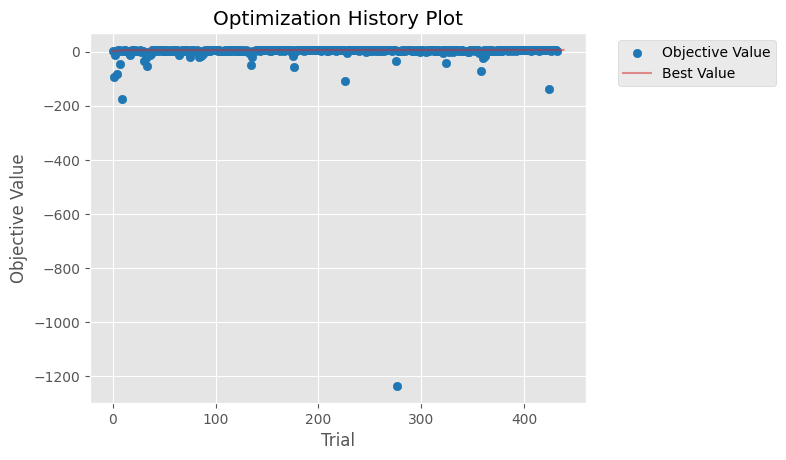

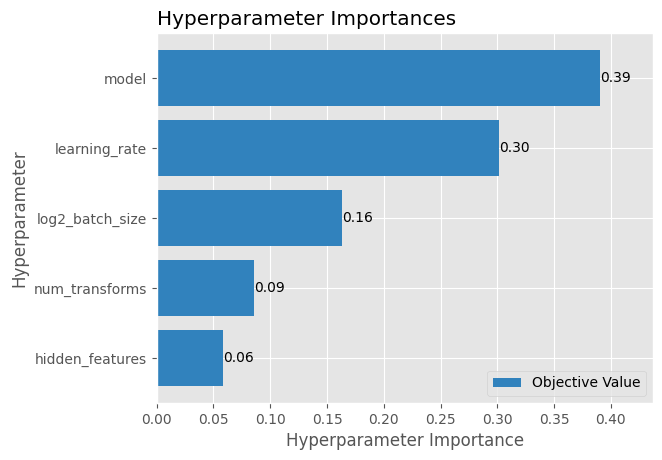

In [17]:
model_library = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/sci-2-dim-models'
model_name = 'tailed_power'  # 'tailed_power' or 'uniform_power'

model_dir = join(model_library, model_name)
net_dir = join(model_dir, 'nets')

study = optuna.load_study(
    study_name=model_name,
    storage='sqlite:///'+join(model_dir, 'optuna_study.db')
)

plot_optimization_history(study)
plot_param_importances(study)

# Collect log probabilities from all experiments

net_paths = os.listdir(net_dir)

log_probs = []
for dname in net_paths:
    exp_dir = join(net_dir, dname)
    log_prob_file = join(exp_dir, 'log_prob_test.txt')
    if os.path.exists(log_prob_file):
        with open(log_prob_file, 'r') as f:
            log_prob = float(f.read().strip())
        log_probs.append(log_prob)
    else:
        log_probs.append(-np.inf)
log_probs = np.array(log_probs)

print(f"Collected log probabilities from {len(log_probs)} experiments.")

Nnets = 5  # number of top nets to ensemble
weighted = True  # whether to weight by log prob

top_nets = np.argsort(log_probs)[::-1][:Nnets]
print(f'Selected nets: {[net_paths[i] for i in top_nets]}')

ensemble_list = []
for i in top_nets:
    model_path = join(net_dir, net_paths[i], 'posterior.pkl')
    pi = load_posterior(model_path, 'cpu')
    ensemble_list.append(pi.posteriors[0])

if weighted:
    ensemble_logprobs = log_probs[top_nets]
    weights = scipy.special.softmax(ensemble_logprobs)
    weights = torch.Tensor(weights)
else:
    weights = torch.ones(len(top_nets)) / len(top_nets)

ensemble = LampeEnsemble(
    posteriors=ensemble_list,
    weights=weights  # equally weighted
)

# save ensemble
with open(join(model_dir, 'ensemble.pkl'), "wb") as handle:
    pickle.dump(ensemble, handle)

INFO:root:Sampling models with [228, 207, 198, 195, 175] samples each.
Drawing 175 posterior samples: 100%|██████████| 175/175 [00:00<00:00, 287.92it/s]


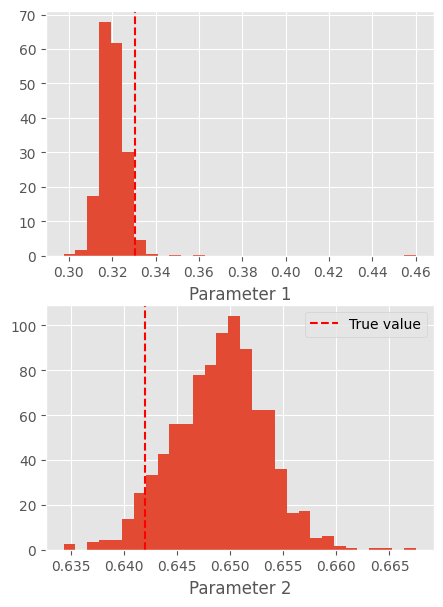

In [18]:
ind = 11
x0, y0 = x_uniform_test[ind], theta_uniform_test[ind]

out = ensemble.sample((1000,), x0).cpu().numpy()
f, axs = plt.subplots(2, 1, figsize=(5, 7))
ax = axs[0]
ax.hist(out[:, 0], bins=30, density=True)
ax.axvline(y0[0].cpu(), color='red', linestyle='--', label='True value')
ax.set_xlabel('Parameter 1')

ax = axs[1]
ax.hist(out[:, 1], bins=30, density=True)
ax.axvline(y0[1].cpu(), color='red', linestyle='--', label='True value')
ax.set_xlabel('Parameter 2')
ax.legend()